In [1]:
!pip install xgboost
!pip install imblearn



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler,label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score, f1_score,precision_score, recall_score, roc_auc_score, average_precision_score,roc_curve, precision_recall_curve, hamming_loss,auc
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data=pd.read_csv("/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_1.csv")
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_2.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_3.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_4.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/final_1.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/final_2.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/final_3.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/final_4.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/final_5.csv")])

/tmp/ipython-input-3093493103.py:1: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv("/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_1.csv")
/tmp/ipython-input-3093493103.py:2: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_2.csv")])
/tmp/ipython-input-3093493103.py:3: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_3.csv")])
/tmp/ipython-input-3093493103.py:4: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_4.csv")])


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3679172 entries, 0 to 431
Data columns (total 46 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   pkSeqID                           int64  
 1   stime                             float64
 2   flgs                              object 
 3   flgs_number                       int64  
 4   proto                             object 
 5   proto_number                      int64  
 6   saddr                             object 
 7   sport                             object 
 8   daddr                             object 
 9   dport                             object 
 10  pkts                              int64  
 11  bytes                             int64  
 12  state                             object 
 13  state_number                      int64  
 14  ltime                             float64
 15  seq                               int64  
 16  dur                               float64
 17

In [6]:
data.columns

Index(['pkSeqID', 'stime', 'flgs', 'flgs_number', 'proto', 'proto_number',
       'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes', 'state',
       'state_number', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum', 'min',
       'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate',
       'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto',
       'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP',
       'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport',
       'AR_P_Proto_P_Dport', 'Pkts_P_State_P_Protocol_P_DestIP',
       'Pkts_P_State_P_Protocol_P_SrcIP', 'attack', 'category', 'subcategory'],
      dtype='object')

In [7]:
data=data.drop_duplicates()

In [8]:
#dropping irrelevant features
data=data.drop(columns=["pkSeqID","stime","flgs","proto","saddr","sport","daddr","dport","state","ltime","seq"])

In [9]:
#dropping correlated columns
data=data.drop(columns=["bytes","max","spkts","sbytes","dbytes","AR_P_Proto_P_Dport","state_number","dpkts"])

In [10]:
data.isnull().sum()

,0
flgs_number,0
proto_number,0
pkts,0
dur,0
mean,0
stddev,0
sum,0
min,0
rate,0
srate,0


In [11]:
data.head()

,flgs_number,proto_number,pkts,dur,mean,stddev,sum,min,rate,srate,...,AR_P_Proto_P_SrcIP,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,1,1,8,7.056393,0.068909,0.068909,0.137818,0.000000,0.992008,0.566862,...,1.142970,1.12704,96,75,1.133720,770,602,1,DoS,HTTP
1,1,2,2,0.000131,0.000131,0.000000,0.000131,0.000131,7633.588379,0.000000,...,0.003857,15267.20000,1,2,0.005142,2,6,1,DoS,HTTP
2,1,1,8,7.047852,0.064494,0.064494,0.128988,0.000000,0.993210,0.567549,...,1.142970,1.12704,96,75,1.135100,770,602,1,DoS,HTTP
3,1,1,8,7.047592,0.064189,0.064189,0.128378,0.000000,0.993247,0.567570,...,1.142970,1.12704,96,75,1.135140,770,602,1,DoS,HTTP
4,1,1,8,7.046841,0.063887,0.063887,0.127774,0.000000,0.993353,0.567630,...,1.142970,1.12704,96,75,1.135260,770,602,1,DoS,HTTP


In [12]:

categories_to_reduce = ['DDoS', 'DoS', 'Reconnaissance']
target_count = 30000

def reduce_samples(df, categories, target_count):
    reduced_df = pd.DataFrame()

    for category in categories:
        category_df = df[df['category'] == category]
        print(f"Original count for {category}: {len(category_df)}")

        if len(category_df) > target_count:
            category_df = category_df.sample(n=target_count, random_state=42)
            print(f"Reduced to {len(category_df)} for {category}")
        else:
            print(f"No reduction needed for {category}")

        reduced_df = pd.concat([reduced_df, category_df], ignore_index=True)

    other_df = df[~df['category'].isin(categories)]
    reduced_df = pd.concat([reduced_df, other_df], ignore_index=True)

    return reduced_df

data = reduce_samples(data, categories_to_reduce, target_count)



Original count for DDoS: 1926624
Reduced to 30000 for DDoS
Original count for DoS: 1650260
Reduced to 30000 for DoS
Original count for Reconnaissance: 91082
Reduced to 30000 for Reconnaissance


In [13]:
data['category'].value_counts()

,count
category,
DDoS,30000
DoS,30000
Reconnaissance,30000
Normal,9549
Theft,1657


In [14]:
data["attack"].value_counts()

,count
attack,
1,91657
0,9549


In [15]:
data["subcategory"].value_counts()

,count
subcategory,
UDP,33632
TCP,26327
Service_Scan,24162
Normal,9549
OS_Fingerprint,5838
Keylogging,1537
Data_Exfiltration,120
HTTP,41


In [16]:
le = LabelEncoder()
data['category'] = le.fit_transform(data['category'])
data['subcategory'] = le.fit_transform(data['subcategory'])
data.head()

,flgs_number,proto_number,pkts,dur,mean,stddev,sum,min,rate,srate,...,AR_P_Proto_P_SrcIP,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,1,3,15,13.955115,3.982232,1.413917,11.946695,1.982758,1.003216,1.003216,...,1.074890,1.037410,100,93,1.074870,1451,1395,1,0,7
1,1,3,14,13.962423,3.987533,0.821593,11.962599,2.983338,0.931070,0.931070,...,1.055830,0.958112,100,62,1.002690,1332,914,1,0,7
2,2,1,5,12.984385,2.199934,1.563204,6.599802,0.000000,0.308062,0.308062,...,0.426398,0.426398,100,100,0.385078,360,360,1,0,6
3,1,3,8,14.194972,3.381320,0.950962,10.143960,2.036473,0.493132,0.493132,...,0.563580,0.563580,100,100,0.563580,800,800,1,0,7
4,1,1,3,0.210202,0.210202,0.000000,0.210202,0.210202,9.514658,4.757329,...,21.318300,21.318300,100,100,14.272000,114,114,1,0,6


In [17]:
Y = data[['attack','category','subcategory']]
X= data.drop(['attack','category','subcategory'],axis=1)

In [18]:
X.head()

,flgs_number,proto_number,pkts,dur,mean,stddev,sum,min,rate,srate,...,TnP_PDstIP,TnP_PerProto,TnP_Per_Dport,AR_P_Proto_P_SrcIP,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP
0,1,3,15,13.955115,3.982232,1.413917,11.946695,1.982758,1.003216,1.003216,...,1451,1451,1451,1.074890,1.037410,100,93,1.074870,1451,1395
1,1,3,14,13.962423,3.987533,0.821593,11.962599,2.983338,0.931070,0.931070,...,1332,1332,1332,1.055830,0.958112,100,62,1.002690,1332,914
2,2,1,5,12.984385,2.199934,1.563204,6.599802,0.000000,0.308062,0.308062,...,556,556,556,0.426398,0.426398,100,100,0.385078,360,360
3,1,3,8,14.194972,3.381320,0.950962,10.143960,2.036473,0.493132,0.493132,...,800,800,800,0.563580,0.563580,100,100,0.563580,800,800
4,1,1,3,0.210202,0.210202,0.000000,0.210202,0.210202,9.514658,4.757329,...,176,176,176,21.318300,21.318300,100,100,14.272000,114,114


In [19]:
#mutual information
mi_attack = mutual_info_classif(X, Y["attack"])
mi_subcat = mutual_info_classif(X, Y["subcategory"])
mi_cat    = mutual_info_classif(X, Y["category"])
mi_avg = (mi_attack + mi_subcat + mi_cat) / 3

df_mi = pd.DataFrame({
    'feature': X.columns.tolist(),
    'MI_attack': mi_attack,
    'MI_subcategory': mi_subcat,
    'MI_category': mi_cat,
    'MI_average': mi_avg
})

df_mi_sorted = df_mi.sort_values(by='MI_average', ascending=False)
top_features = df_mi_sorted.head(20)['feature'].tolist()
X = X[top_features]


In [20]:
X.head()

,AR_P_Proto_P_DstIP,AR_P_Proto_P_SrcIP,AR_P_Proto_P_Sport,TnBPDstIP,TnBPSrcIP,dur,rate,TnP_Per_Dport,TnP_PerProto,TnP_PDstIP,srate,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,TnP_PSrcIP,sum,mean,pkts,min,stddev,N_IN_Conn_P_DstIP
0,1.037410,1.074890,1.074870,87060,83700,13.955115,1.003216,1451,1451,1451,1.003216,1451,1395,1395,11.946695,3.982232,15,1.982758,1.413917,100
1,0.958112,1.055830,1.002690,79920,54840,13.962423,0.931070,1332,1332,1332,0.931070,1332,914,914,11.962599,3.987533,14,2.983338,0.821593,100
2,0.426398,0.426398,0.385078,80360,80360,12.984385,0.308062,556,556,556,0.308062,360,360,556,6.599802,2.199934,5,0.000000,1.563204,100
3,0.563580,0.563580,0.563580,48000,48000,14.194972,0.493132,800,800,800,0.493132,800,800,800,10.143960,3.381320,8,2.036473,0.950962,100
4,21.318300,21.318300,14.272000,19960,19960,0.210202,9.514658,176,176,176,4.757329,114,114,176,0.210202,0.210202,3,0.210202,0.000000,100


In [21]:
#tree based feature selection
model = XGBClassifier(tree_method='hist', n_jobs=-1)
model.fit(X, Y["attack"])


model2 = XGBClassifier(tree_method='hist', n_jobs=-1)
model2.fit(X, Y["category"])


importances = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features = importance_df['feature'].head(15)



importances = model2.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features2 = importance_df['feature'].head(15)


combined_features = set(top_features) | set(top_features2)
X = X[list(combined_features)]

In [22]:
X.head()

,Pkts_P_State_P_Protocol_P_DestIP,TnBPSrcIP,Pkts_P_State_P_Protocol_P_SrcIP,srate,TnBPDstIP,TnP_PerProto,rate,TnP_PDstIP,dur,AR_P_Proto_P_DstIP,AR_P_Proto_P_SrcIP,sum,TnP_PSrcIP,stddev,N_IN_Conn_P_DstIP,TnP_Per_Dport,min,AR_P_Proto_P_Sport
0,1451,83700,1395,1.003216,87060,1451,1.003216,1451,13.955115,1.037410,1.074890,11.946695,1395,1.413917,100,1451,1.982758,1.074870
1,1332,54840,914,0.931070,79920,1332,0.931070,1332,13.962423,0.958112,1.055830,11.962599,914,0.821593,100,1332,2.983338,1.002690
2,360,80360,360,0.308062,80360,556,0.308062,556,12.984385,0.426398,0.426398,6.599802,556,1.563204,100,556,0.000000,0.385078
3,800,48000,800,0.493132,48000,800,0.493132,800,14.194972,0.563580,0.563580,10.143960,800,0.950962,100,800,2.036473,0.563580
4,114,19960,114,4.757329,19960,176,9.514658,176,0.210202,21.318300,21.318300,0.210202,176,0.000000,100,176,0.210202,14.272000


In [23]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)


In [25]:
# Smote Oversampling
y_all = y_train[['attack', 'category', 'subcategory']].reset_index(drop=True)

sm = SMOTE(k_neighbors=3, random_state=42)
X_resampled, y_attack_resampled = sm.fit_resample(X_train, y_all['attack'])

n_original = len(X_train)
n_total = len(X_resampled)
n_synthetic = n_total - n_original

normal_cat = le.transform(["Normal"])[0]
normal_subcat = le.transform(["Normal"])[0]

y_category_resampled = pd.concat([
    y_all['category'],
    pd.Series([normal_cat] * n_synthetic)
], ignore_index=True)

y_subcategory_resampled = pd.concat([
    y_all['subcategory'],
    pd.Series([normal_subcat] * n_synthetic)
], ignore_index=True)

y_train_resampled = pd.DataFrame({
    "attack": y_attack_resampled,
    "category": y_category_resampled,
    "subcategory": y_subcategory_resampled
})

X_train = X_resampled
y_train = y_train_resampled



In [26]:
class RandomForest:
    def __init__(self,max_depth):
        self.rfc_attack = RandomForestClassifier(max_depth=max_depth)
        self.rfc_category = RandomForestClassifier(max_depth=max_depth)
        self.rfc_subcategory = RandomForestClassifier(max_depth=max_depth)

    def fit(self,X_train,y_train):
        self.rfc_attack.fit(X_train,y_train['attack'])

        features_category = np.concatenate((X_train,np.array(y_train['attack']).reshape(-1,1)),axis=1)
        self.rfc_category.fit(features_category,y_train['category'])

        features_subcategory = np.concatenate((features_category,np.array(y_train['category']).reshape(-1,1)),axis=1)
        self.rfc_subcategory.fit(features_subcategory,y_train['subcategory'])

    def predict(self,X_test):
        predict_attack = self.rfc_attack.predict(X_test)
        y_proba=self.rfc_attack.predict_proba(X_test)[:,1]
        test_category = np.concatenate((X_test,predict_attack.reshape(-1,1)),axis=1)
        predict_category = self.rfc_category.predict(test_category)

        test_subcategory = np.concatenate((test_category,predict_category.reshape(-1,1)),axis=1)
        predict_subcategory = self.rfc_subcategory.predict(test_subcategory)

        return pd.DataFrame({'attack':predict_attack,'category':predict_category,'subcategory':predict_subcategory,"y_proba":y_proba})

In [27]:
def display_metrics(y_true, y_pred, title, y_proba=None):
    print(f"\n--- {title} ---")

    print("\n📋 Classification Report:")
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print(df_report.iloc[:-3])
    print("\n📊 Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    acc = accuracy_score(y_true, y_pred)
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    ham_loss = hamming_loss(y_true, y_pred)

    print(f"\n✅ Accuracy: {acc:.4f}")
    print(f"✅ Weighted F1 Score: {f1_weighted:.4f}")
    print(f"✅ Macro F1 Score: {f1_macro:.4f}")
    print(f"✅ Macro Precision: {precision_macro:.4f}")
    print(f"✅ Macro Recall: {recall_macro:.4f}")
    print(f"❌ Hamming Loss: {ham_loss:.6f}")

    if y_proba is not None:
        n_classes = pd.Series(y_true).nunique()
        if n_classes == 2:
            roc_auc = roc_auc_score(y_true, y_proba)
            pr_auc = average_precision_score(y_true, y_proba)
            print(f"📈 ROC AUC Score: {roc_auc:.4f}")
            print(f"📈 PR AUC Score: {pr_auc:.4f}")

            fpr, tpr, _ = roc_curve(y_true, y_proba)
            plt.figure()
            plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            precision, recall, _ = precision_recall_curve(y_true, y_proba)
            plt.figure()
            plt.plot(recall, precision, label=f"AP = {pr_auc:.2f}")
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title("Precision-Recall Curve")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

**Random Forest**

In [28]:
rf = RandomForest(max_depth=3)
rf.fit(X_train,y_train)

predictions_rfc = rf.predict(X_test)




--- Attack Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.960854  0.989529  0.974981   1910.0
1   0.998906  0.995800  0.997350  18332.0

📊 Confusion Matrix:


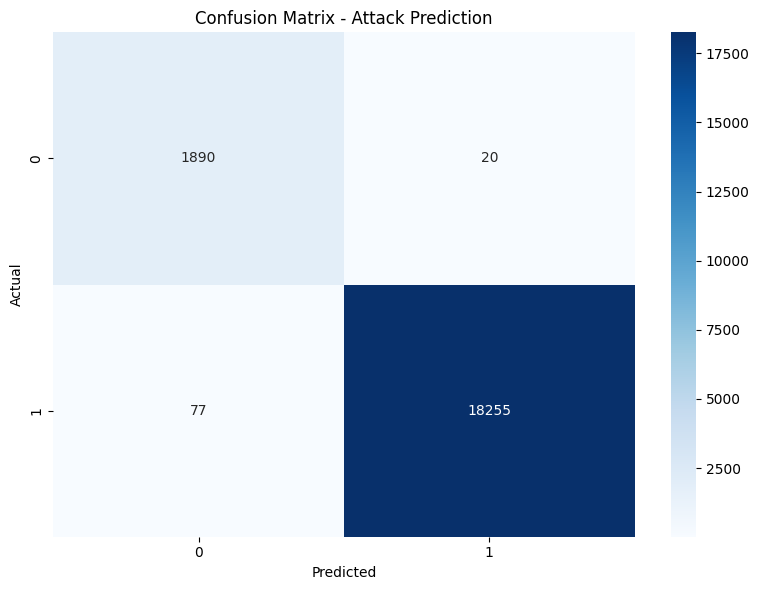


✅ Accuracy: 0.9952
✅ Weighted F1 Score: 0.9952
✅ Macro F1 Score: 0.9862
✅ Macro Precision: 0.9799
✅ Macro Recall: 0.9927
❌ Hamming Loss: 0.004792
📈 ROC AUC Score: 0.9998
📈 PR AUC Score: 1.0000


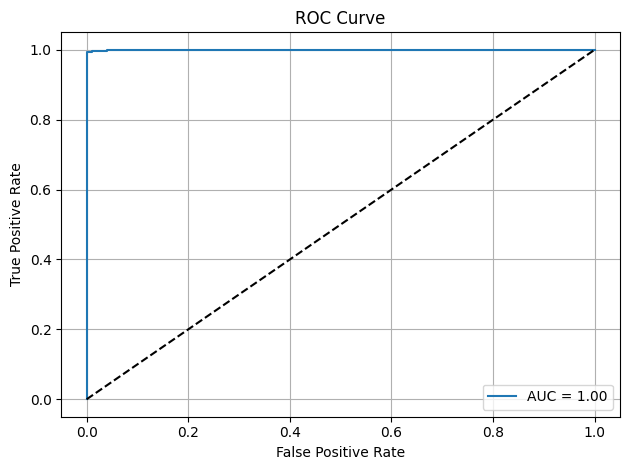

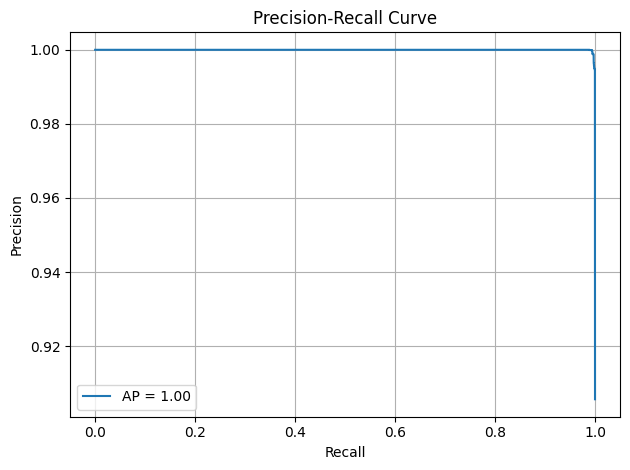

In [29]:
display_metrics(y_test['attack'], predictions_rfc['attack'], "Attack Prediction",predictions_rfc["y_proba"])


--- Category Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.996846  0.790167  0.881554   6000.0
1   0.866092  0.954000  0.907923   6000.0
2   0.000000  0.000000  0.000000   1910.0
3   0.694161  0.998500  0.818971   6001.0
4   1.000000  0.740181  0.850694    331.0

📊 Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


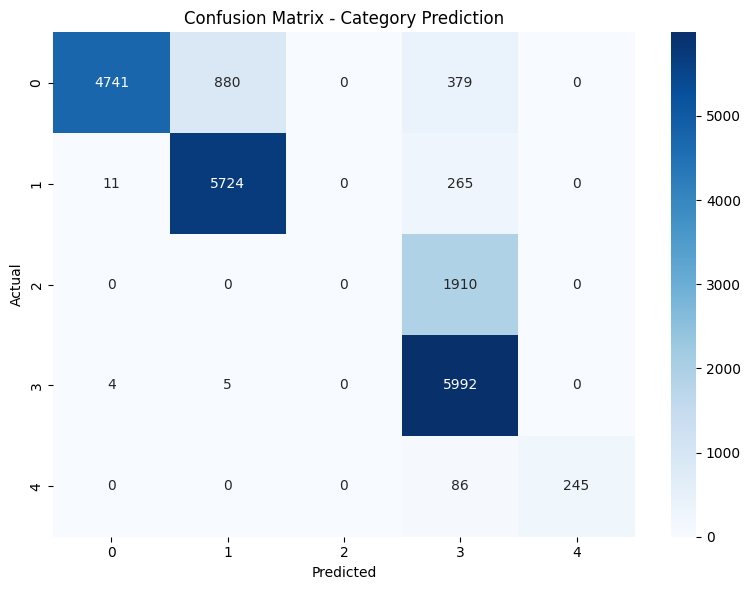


✅ Accuracy: 0.8251
✅ Weighted F1 Score: 0.7871
✅ Macro F1 Score: 0.6918
✅ Macro Precision: 0.7114
✅ Macro Recall: 0.6966
❌ Hamming Loss: 0.174884


In [30]:
display_metrics(y_test['category'], predictions_rfc['category'], "Category Prediction")


--- Subcategory Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.000000  0.000000  0.000000     24.0
1   0.000000  0.000000  0.000000      9.0
2   0.975510  0.778502  0.865942    307.0
3   0.960854  0.989529  0.974981   1910.0
4   0.000000  0.000000  0.000000   1168.0
5   0.724681  0.999379  0.840146   4833.0
6   0.963208  0.800570  0.874391   5265.0
7   0.940764  0.977550  0.958804   6726.0

📊 Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


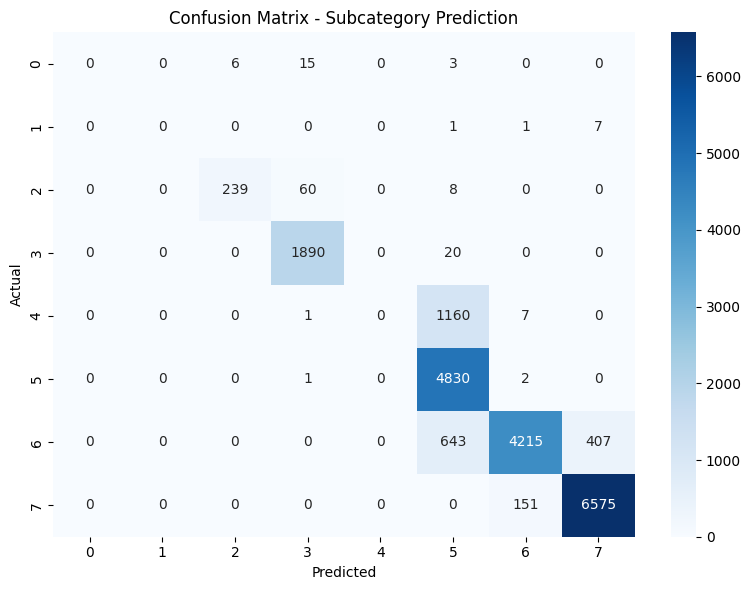


✅ Accuracy: 0.8768
✅ Weighted F1 Score: 0.8517
✅ Macro F1 Score: 0.5643
✅ Macro Precision: 0.5706
✅ Macro Recall: 0.5682
❌ Hamming Loss: 0.123160


In [31]:
display_metrics(y_test['subcategory'], predictions_rfc['subcategory'], "Subcategory Prediction")

XGB graddient boosting


In [32]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train["attack"])

# Predict
y_pred_xgb = xgb_model.predict(X_test)

y_proba = xgb_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:43:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Attack Prediction ---

📋 Classification Report:
   precision  recall  f1-score  support
0        1.0     1.0       1.0   1910.0
1        1.0     1.0       1.0  18332.0

📊 Confusion Matrix:


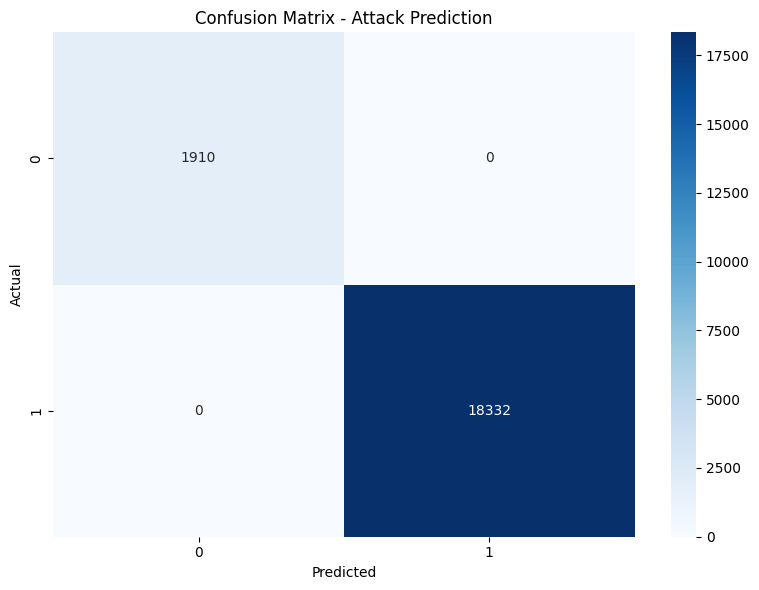


✅ Accuracy: 1.0000
✅ Weighted F1 Score: 1.0000
✅ Macro F1 Score: 1.0000
✅ Macro Precision: 1.0000
✅ Macro Recall: 1.0000
❌ Hamming Loss: 0.000000
📈 ROC AUC Score: 1.0000
📈 PR AUC Score: 1.0000


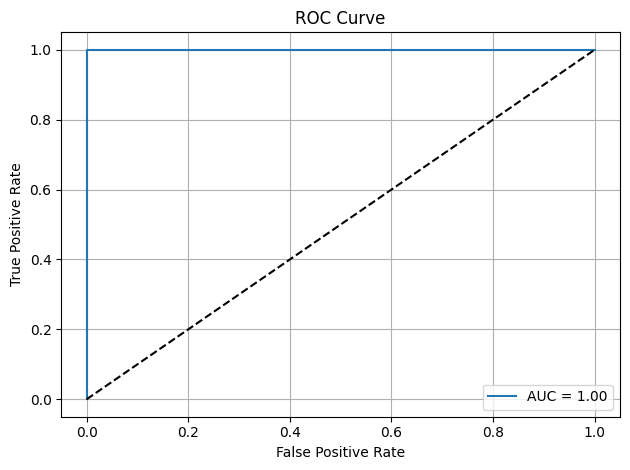

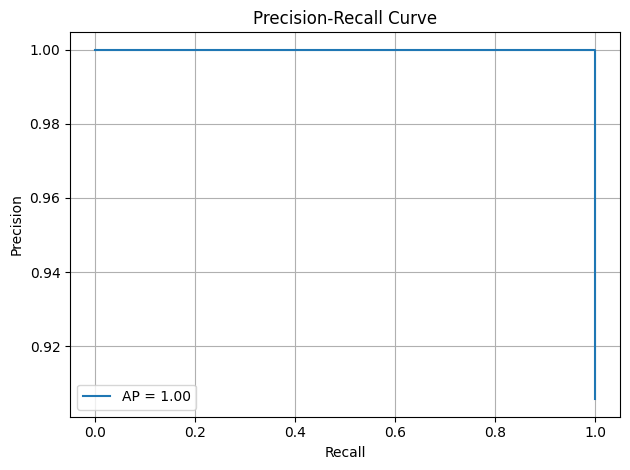

In [33]:
display_metrics(y_test['attack'], y_pred_xgb, "Attack Prediction",y_proba)

In [34]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train["category"])

# Predict
y_pred_xgb = xgb_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:43:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Category Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.999833  0.999333  0.999583   6000.0
1   0.999334  1.000000  0.999667   6000.0
2   1.000000  0.042408  0.081366   1910.0
3   0.766284  0.999833  0.867616   6001.0
4   1.000000  0.996979  0.998487    331.0

📊 Confusion Matrix:


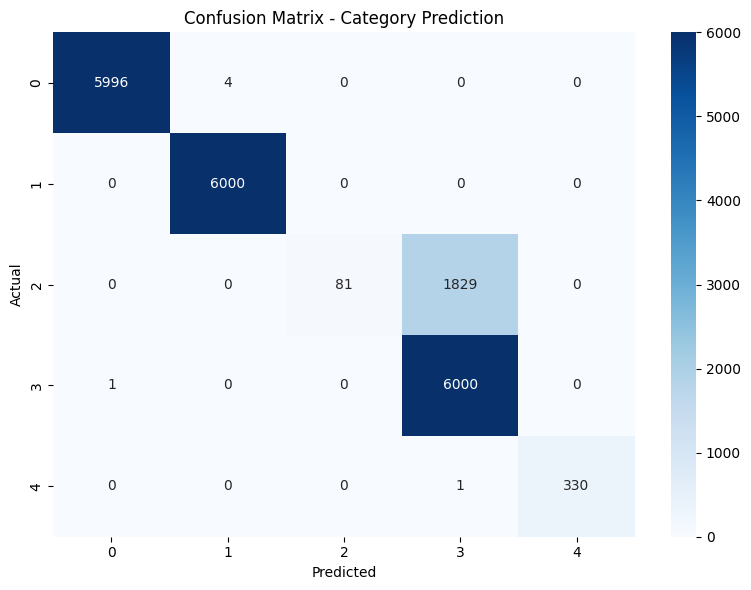


✅ Accuracy: 0.9093
✅ Weighted F1 Score: 0.8738
✅ Macro F1 Score: 0.7893
✅ Macro Precision: 0.9531
✅ Macro Recall: 0.8077
❌ Hamming Loss: 0.090653


In [35]:
display_metrics(y_test['category'], y_pred_xgb, "Category Prediction")

In [36]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train["subcategory"])

# Predict
y_pred_xgb = xgb_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:43:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Subcategory Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.700000  0.583333  0.636364     24.0
1   1.000000  0.888889  0.941176      9.0
2   0.967638  0.973941  0.970779    307.0
3   0.998954  1.000000  0.999477   1910.0
4   0.931483  0.919521  0.925463   1168.0
5   0.980611  0.983654  0.982130   4833.0
6   0.999810  1.000000  0.999905   5265.0
7   1.000000  1.000000  1.000000   6726.0

📊 Confusion Matrix:


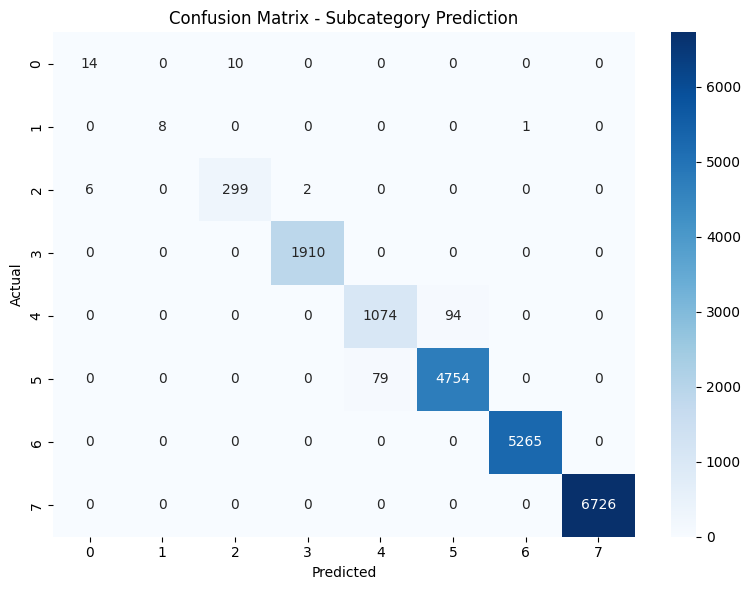


✅ Accuracy: 0.9905
✅ Weighted F1 Score: 0.9905
✅ Macro F1 Score: 0.9319
✅ Macro Precision: 0.9473
✅ Macro Recall: 0.9187
❌ Hamming Loss: 0.009485


In [37]:
display_metrics(y_test['subcategory'], y_pred_xgb, "Subcategory Prediction")

Logistic Regression


In [38]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train["attack"])

# Predict
y_pred_logreg = logreg_model.predict(X_test)

y_proba = logreg_model.predict_proba(X_test)[:, 1]


--- Attack Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.997862  0.977487  0.987569   1910.0
1   0.997659  0.999782  0.998719  18332.0

📊 Confusion Matrix:


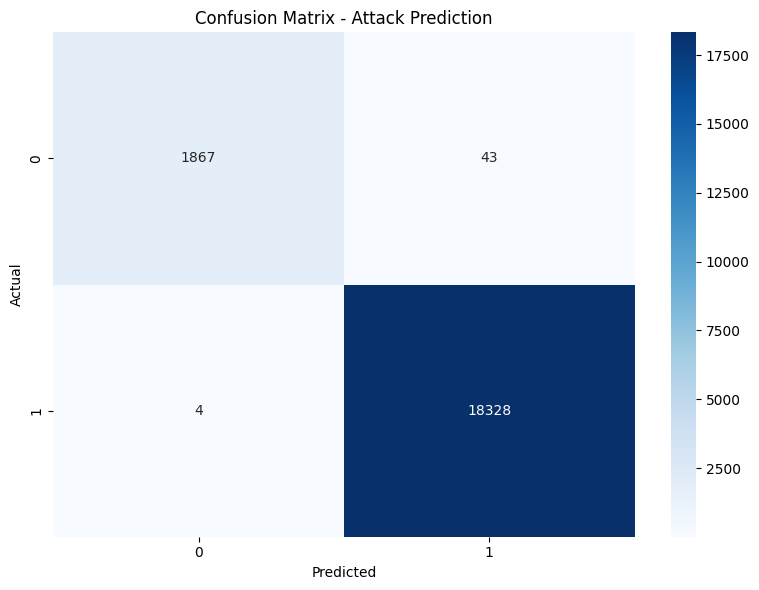


✅ Accuracy: 0.9977
✅ Weighted F1 Score: 0.9977
✅ Macro F1 Score: 0.9931
✅ Macro Precision: 0.9978
✅ Macro Recall: 0.9886
❌ Hamming Loss: 0.002322
📈 ROC AUC Score: 0.9980
📈 PR AUC Score: 0.9992


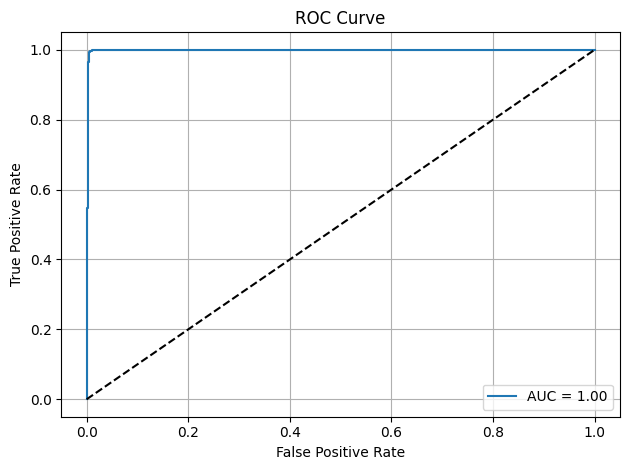

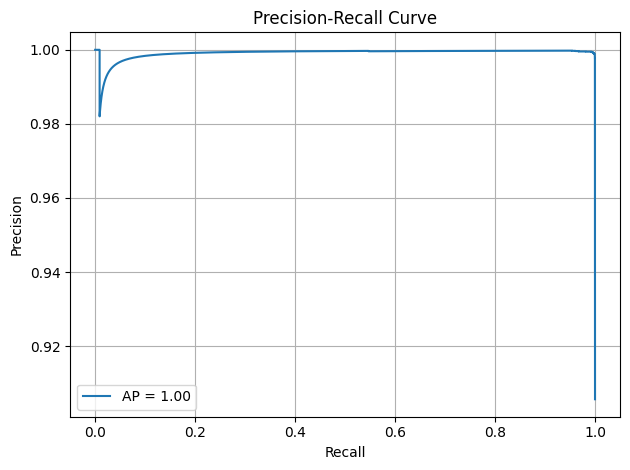

In [39]:
display_metrics(y_test['attack'], y_pred_logreg, "Attack Prediction",y_proba)


In [40]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train["category"])

# Predict
y_pred_logreg = logreg_model.predict(X_test)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Category Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.788983  0.888000  0.835568   6000.0
1   0.872704  0.783833  0.825885   6000.0
2   0.000000  0.000000  0.000000   1910.0
3   0.694166  0.900183  0.783864   6001.0
4   1.000000  0.960725  0.979969    331.0

📊 Confusion Matrix:


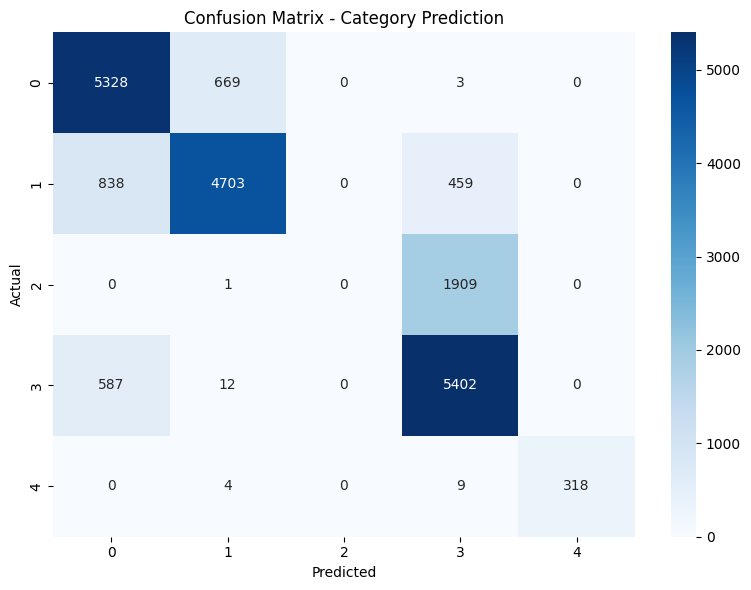


✅ Accuracy: 0.7781
✅ Weighted F1 Score: 0.7409
✅ Macro F1 Score: 0.6851
✅ Macro Precision: 0.6712
✅ Macro Recall: 0.7065
❌ Hamming Loss: 0.221865


In [41]:
display_metrics(y_test['category'], y_pred_logreg, "Category Prediction")

In [42]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train["subcategory"])

# Predict
y_pred_logreg = logreg_model.predict(X_test)


--- Subcategory Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.000000  0.000000  0.000000     24.0
1   0.000000  0.000000  0.000000      9.0
2   0.936909  0.967427  0.951923    307.0
3   0.992163  0.994241  0.993201   1910.0
4   0.500000  0.000856  0.001709   1168.0
5   0.768993  0.875440  0.818771   4833.0
6   0.849212  0.860019  0.854581   5265.0
7   0.916516  0.977698  0.946119   6726.0

📊 Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


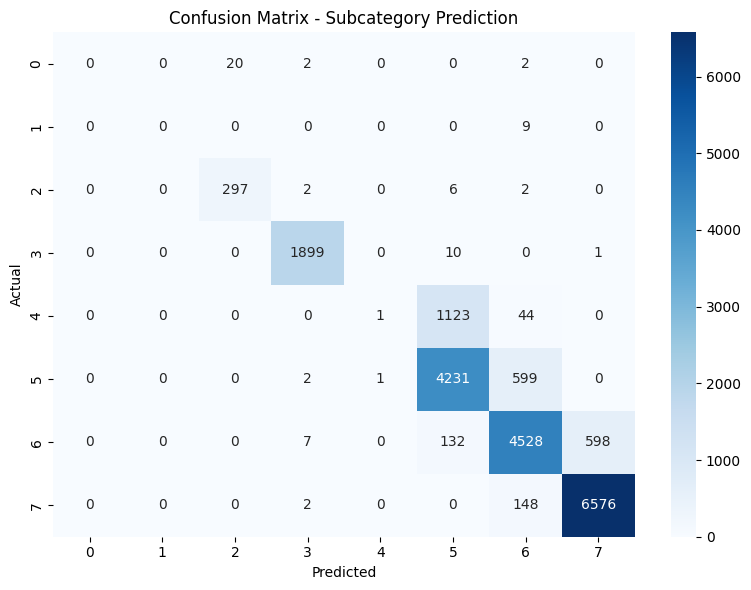


✅ Accuracy: 0.8661
✅ Weighted F1 Score: 0.8404
✅ Macro F1 Score: 0.5708
✅ Macro Precision: 0.6205
✅ Macro Recall: 0.5845
❌ Hamming Loss: 0.133880


In [43]:
display_metrics(y_test['subcategory'], y_pred_logreg, "Subcategory Prediction")

Stacked Model

In [44]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
rf = RandomForestClassifier(class_weight="balanced")
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=200,class_weight="balanced")


stacked = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf)],
    final_estimator=meta_model,
    cv=cv,
    passthrough=False,
    n_jobs=1
)


stacked.fit(X_train, y_train["attack"])



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:46:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:46:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:46:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:47:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'mult

StackingClassifier(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None,
                                              feature_weights=None,...
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced'))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      max_iter=200,
                                                      multi_class='multinomial'),
                   n_jobs=1)


--- Attack ---

📋 Classification Report:
   precision  recall  f1-score  support
0        1.0     1.0       1.0   1910.0
1        1.0     1.0       1.0  18332.0

📊 Confusion Matrix:


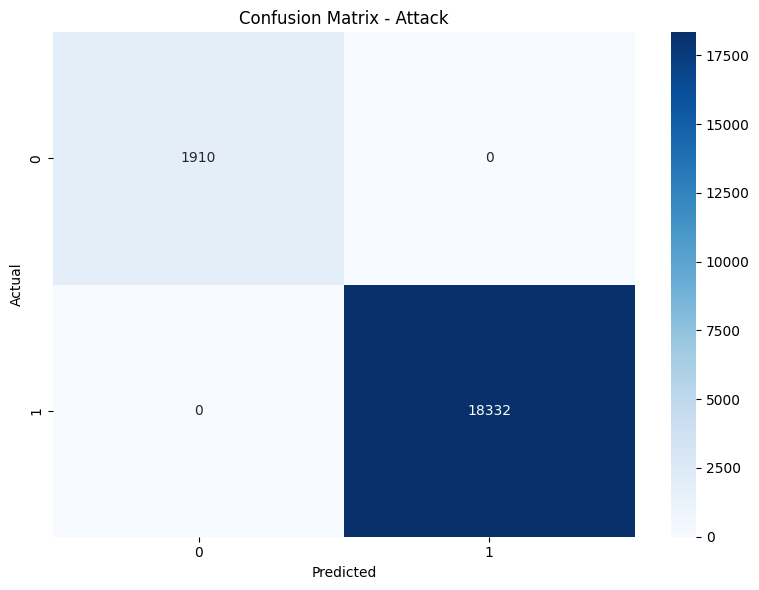


✅ Accuracy: 1.0000
✅ Weighted F1 Score: 1.0000
✅ Macro F1 Score: 1.0000
✅ Macro Precision: 1.0000
✅ Macro Recall: 1.0000
❌ Hamming Loss: 0.000000
📈 ROC AUC Score: 1.0000
📈 PR AUC Score: 1.0000


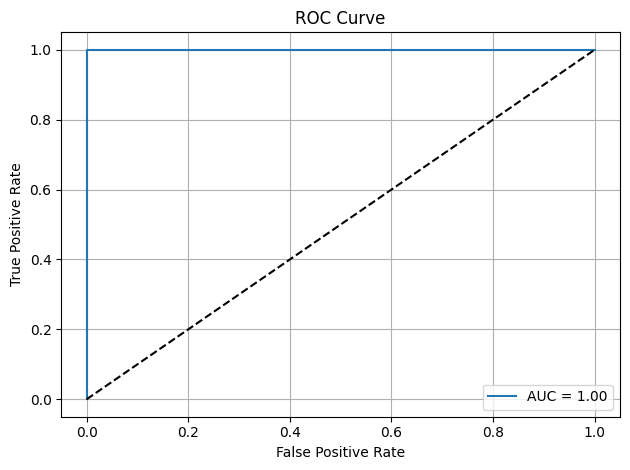

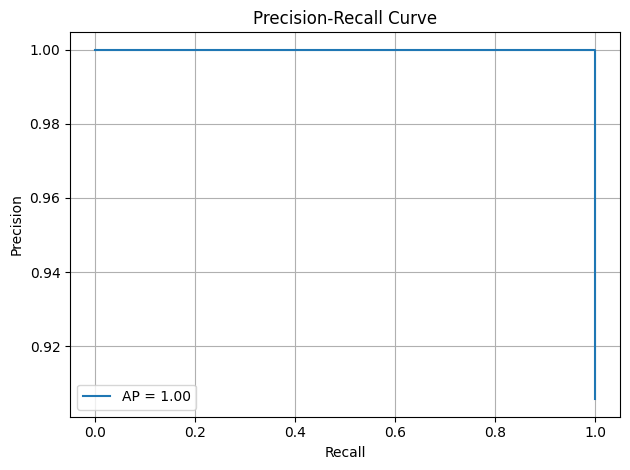

In [45]:
y_pred_attack = stacked.predict(X_test)
y_proba = stacked.predict_proba(X_test)[:, 1]
display_metrics(y_test["attack"], y_pred_attack,"Attack",y_proba)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:00:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:02:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:02:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:02:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'mult


--- category ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.999833  0.999333  0.999583   6000.0
1   0.999334  1.000000  0.999667   6000.0
2   1.000000  0.636126  0.777600   1910.0
3   0.896191  0.999833  0.945180   6001.0
4   1.000000  1.000000  1.000000    331.0

📊 Confusion Matrix:


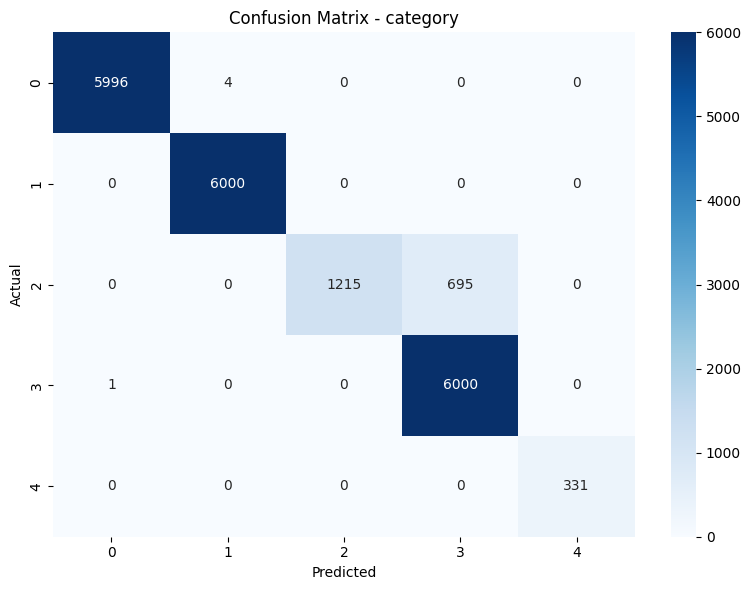


✅ Accuracy: 0.9654
✅ Weighted F1 Score: 0.9625
✅ Macro F1 Score: 0.9444
✅ Macro Precision: 0.9791
✅ Macro Recall: 0.9271
❌ Hamming Loss: 0.034582


In [52]:

stacked = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf)],
    final_estimator=meta_model,
    cv=cv,
    passthrough=False,
    n_jobs=1
)
X_cat = np.concatenate([X_train, y_train["attack"].values.reshape(-1, 1)], axis=1)

stacked.fit(X_cat, y_train["category"])


X_cat_test = np.concatenate([X_test, y_pred_attack.reshape(-1, 1)], axis=1)
y_pred_category = stacked.predict(X_cat_test)

display_metrics(y_test["category"], y_pred_category, title="category")


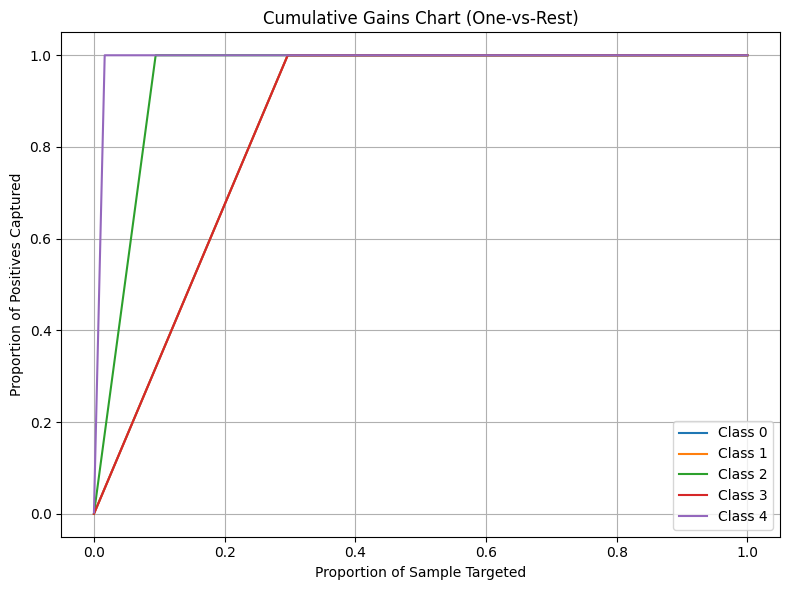

In [57]:
y_score = stacked.predict_proba(X_cat_test)
y_true = np.array(y_test["category"])
classes = [0,1,2,3,4]

plt.figure(figsize=(8,6))

for i in range(len(classes)):
    idx = np.argsort(y_score[:, i])[::-1]
    y_true_sorted = (y_true[idx] == i).astype(int)

    cum_positives = np.cumsum(y_true_sorted)
    total_positives = np.sum(y_true_sorted)

    cum_pct_positives = cum_positives / total_positives
    cum_pct_samples = np.arange(1, len(idx) + 1) / len(idx)

    plt.plot(cum_pct_samples, cum_pct_positives,
             label=f'Class {classes[i]}')

plt.xlabel("Proportion of Sample Targeted")
plt.ylabel("Proportion of Positives Captured")
plt.title("Cumulative Gains Chart (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
stacked = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf)],
    final_estimator=meta_model,
    cv=cv,
    passthrough=False,
    n_jobs=1
)

X_subcat = np.concatenate([X_cat, y_train["category"].values.reshape(-1, 1)], axis=1)

stacked.fit(X_subcat, y_train["subcategory"])
X_subcat_test = np.concatenate([X_cat_test, y_pred_category.reshape(-1, 1)], axis=1)

y_pred = stacked.predict(X_subcat_test)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:51:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:52:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:52:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:52:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'mult


--- Subcategory ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.666667  0.916667  0.771930     24.0
1   0.500000  0.888889  0.640000      9.0
2   0.993289  0.964169  0.978512    307.0
3   1.000000  1.000000  1.000000   1910.0
4   0.974811  0.994007  0.984315   1168.0
5   0.998752  0.993793  0.996266   4833.0
6   0.999810  0.998670  0.999240   5265.0
7   1.000000  1.000000  1.000000   6726.0

📊 Confusion Matrix:


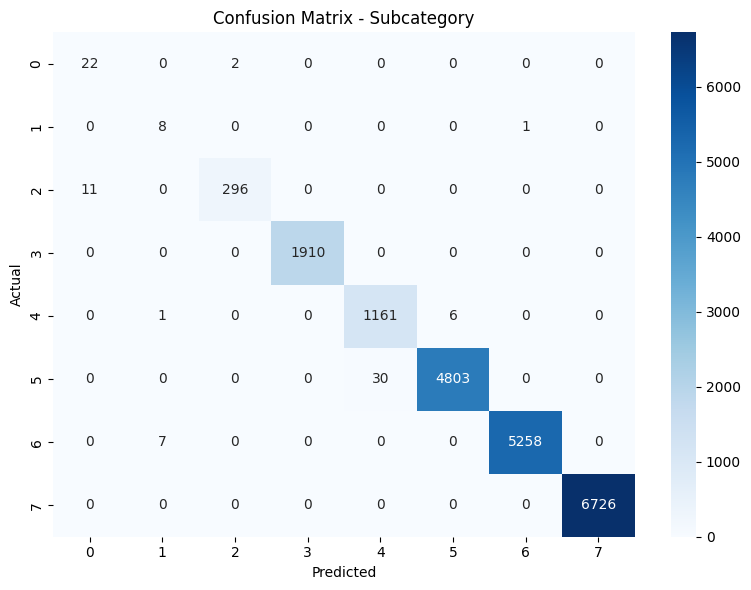


✅ Accuracy: 0.9971
✅ Weighted F1 Score: 0.9972
✅ Macro F1 Score: 0.9213
✅ Macro Precision: 0.8917
✅ Macro Recall: 0.9695
❌ Hamming Loss: 0.002865


In [49]:
display_metrics(y_test["subcategory"], y_pred, title="Subcategory")